# Differences in Block Matrices

In the previous section, we saw a situation where we had two networks which we thought could be effectively characterized with RDPG. Further, we knew that the communities were the same across both networks: that is, we knew that community $1$ in the first network was the same as community $1$ in the second network, so on and so forth all the way up to community $K$. In this situation, we found that we could test whether the latent positions for the underlying RDPGs are the same; that is, whether $H_0: X_1 = X_2R$ against $H_A: H_1 \neq X_2R$. We called this the two-sample hypothesis test for RDPGs. 

What if we can take this a step further, however, and we can say that the networks are realizations of SBMs? How can we check whether the block matrices are the same? If you remember from [Chapter 5.4](#link?), we learned that SBMs are just a "special case" of the RDPG. What this means is that, since the SBM is an RDPG, the SBM also has a latent position matrix. Therefore, we could test whether the networks are the same by just using the two-sample hypothesis test for the RDPG. The interpretation of rejecting/accepting the alternative hypothesis here was that the latent positions were the same/different across the two networks, and therefore, they share the same probability matrix. This is excellent news, so are we done?

Not quite yet; as it turns out, when we think that the networks are realizations of SBMs, there are a lot more interesting questions we can ask about the probabilities that might arise. Specifically, we can deduce many useful ways in which two probability matrices for SBMs might be different, but *still* share similar characteristics.

For this example, we will introduce a new scenario. We have two networks which summarize the traffic patterns between $n=100$ towns (represented by the nodes in our network) across $K=3$ states (represented by the communities in our network). The first 45 towns are in New York (the first community), the second 30 towns are in New Jersey (the second community), and the third 25 towns are in Pennsylvania (the third community). The community assignment vector $\vec z$ looks like this:

In [1]:
import numpy as np

ns = [45, 30, 25]  # number of students

# z is a column vector indicating which state each
# town is in
z = np.array([1 for i in range(0, ns[0])] + 
              [2 for i in range(0, ns[1])] +
              [3 for i in range(0, ns[2])] )

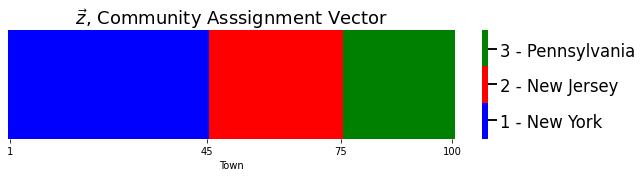

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib

def plot_tau(tau, title="", xlab="Node"):
    cmap = matplotlib.colors.ListedColormap(["blue", 'red', 'green'])
    fig, ax = plt.subplots(figsize=(10,2))
    with sns.plotting_context("talk", font_scale=1):
        ax = sns.heatmap((tau - 1).reshape((1,tau.shape[0])), cmap=cmap,
                        ax=ax, cbar_kws=dict(shrink=1), yticklabels=False,
                        xticklabels=False)
        ax.set_title(title)
        cbar = ax.collections[0].colorbar
        cbar.set_ticks([.35, 1, 1.65])
        cbar.set_ticklabels(['1 - New York', '2 - New Jersey', '3 - Pennsylvania'])
        ax.set(xlabel=xlab)
        ax.set_xticks([.5,44.5, 74.5,99.5])
        ax.set_xticklabels(["1", "45", "75", "100"])
        cbar.ax.set_frame_on(True)
    return

plot_tau(z, title="$\\vec z$, Community Asssignment Vector",
         xlab="Town")

For a month, we measure the number of drivers who commute from one town to the other in a specified time window, and if more than $1,000$ drivers regularly make this commute, we add an edge between the pair of towns. In general, we know that people tend to commute more frequently within their state, so the probabilities that an edge exists between a pair of towns in the same state exceeds the probabilities that an edge exists between a pair of towns which are not in the same state. Now, here's the twist: we have measured the first network between 8 AM and 8 PM (covering the bulk of the work day), and the second network between 8 PM and 8 AM (covering the bulk of night time). We know that a lot of people in New Jersey tend to commute to new York for the work day, so we the probability of an edge existing between a New Jersey town and a New York town are higher during the day than the night. We don't think that driving patterns themselves really change *too* much otherwise, but we do think that the probability of an edge existing is about $50\%$ higher during the daytime. for all pairs of communities in the network. The block matrices look like this:

In [3]:
Bnight = np.array([[.3, .15, .15], [.15, .3, .15], [.15, .15, .3]])
Bday = Bnight*1.5  # day time block matarix is 50% more than night

# people tend to commute from New Jersey to New York during the day
Bday[0, 1] = .4; Bday[1,0] = .4

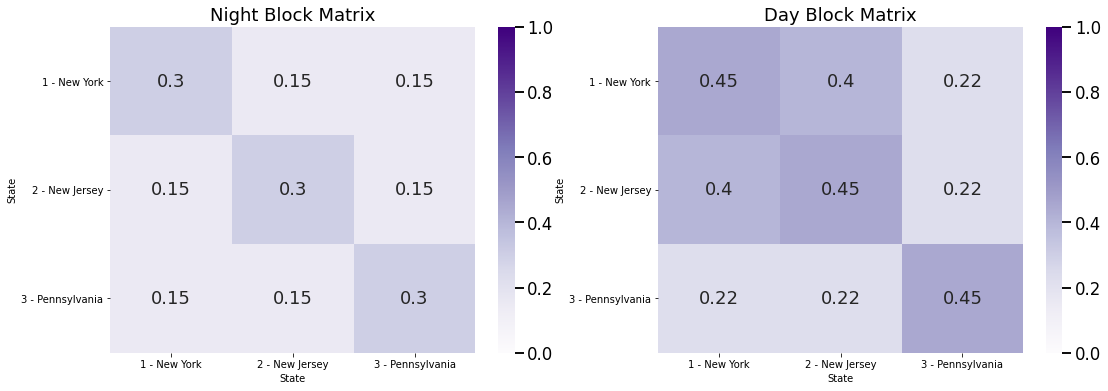

In [4]:
def plot_block(X, title="", blockname="State", blocktix=[0.5, 1.5, 2.5],
               blocklabs=["1 - New York", "2 - New Jersey", "3 - Pennsylvania"],
               ax=None):
    
    with sns.plotting_context("talk", font_scale=1):
        ax = sns.heatmap(X, cmap="Purples",
                        ax=ax, cbar_kws=dict(shrink=1), yticklabels=False,
                        xticklabels=False, vmin=0, vmax=1, annot=True)
        ax.set_title(title)
        cbar = ax.collections[0].colorbar
        ax.set(ylabel=blockname, xlabel=blockname)
        ax.set_yticks(blocktix)
        ax.set_yticklabels(blocklabs)
        ax.set_xticks(blocktix)
        ax.set_xticklabels(blocklabs)
        cbar.ax.set_frame_on(True)
    return

fig, axs = plt.subplots(1, 2, figsize=(18, 6))
plot_block(Bnight, title="Night Block Matrix", ax=axs[0])
plot_block(Bday, title="Day Block Matrix", ax=axs[1])
plt.show()

We then sample two networks with the above parameters, giving us the following two networks for the day and the night:

In [5]:
import graspologic as gp
from graspologic.simulations import sbm

Aday = sbm(ns, Bday)
Anight = sbm(ns, Bnight)

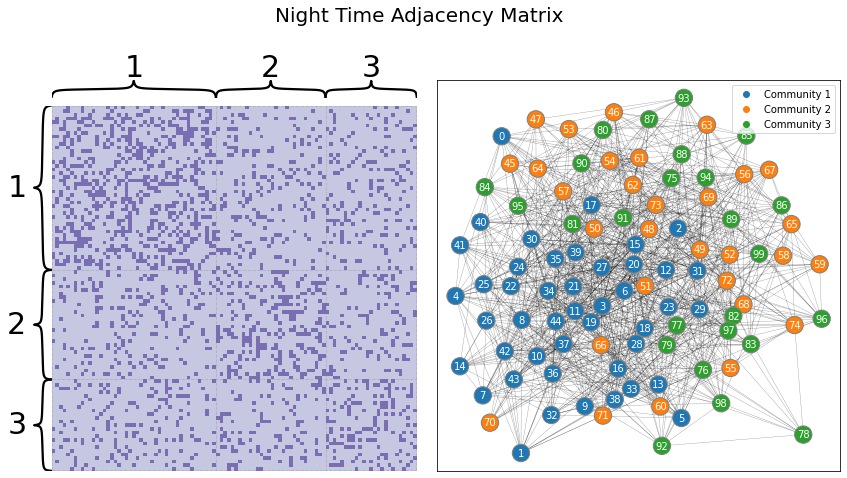

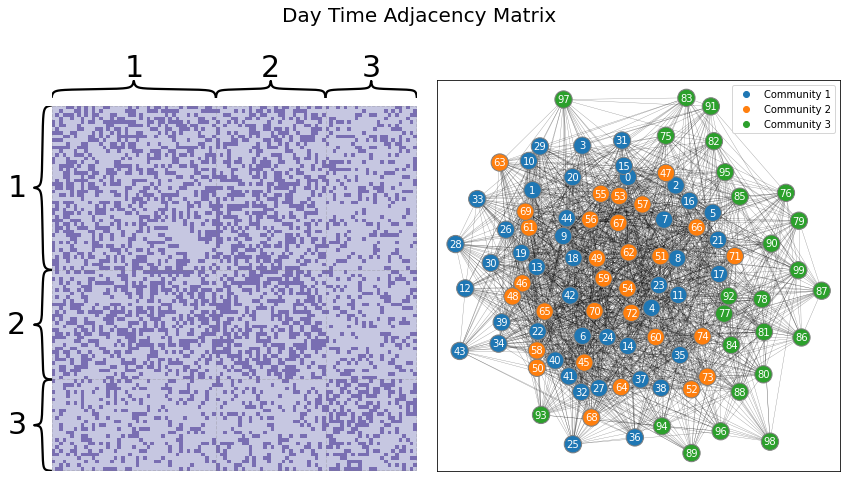

In [6]:
from graphbook_code import draw_multiplot

draw_multiplot(Anight, labels=list(z), title="Night Time Adjacency Matrix");
draw_multiplot(Aday, labels=list(z), title="Day Time Adjacency Matrix");

How can we ask whether the block matrices have similarities?

## Testing whether the block matrices in an SBM are different

Based on what we learned above, we know ahead of time that the block matrices for the SBMs are different. However, how can we actually test this? Well, let's start by being clear about what we mean by "different". To make this a little big more mathemattical, we'll introduce some new variables for the block matrices during the day time ($B^{(d)}$) and at night time ($B^{(n)}$) clearly. The block matrices are:

\begin{align*}
    B^{(d)} &= \begin{bmatrix}
    b^{(d)}_{11} & b^{(d)}_{12} & b^{(d)}_{13} \\
    b^{(d)}_{21} & b^{(d)}_{22} & b^{(d)}_{23} \\
    b^{(d)}_{31} & b^{(d)}_{32} & b^{(d)}_{33}
    \end{bmatrix}; \;\;\; B^{(n)} = \begin{bmatrix}
    b^{(n)}_{11} & b^{(n)}_{12} & b^{(n)}_{13} \\
    b^{(n)}_{21} & b^{(n)}_{22} & b^{(n)}_{23} \\
    b^{(n)}_{31} & b^{(n)}_{32} & b^{(n)}_{33}
    \end{bmatrix}
\end{align*}
The hypothesis we want to test is the null hypothesis that the block matrices are the same, $H_0: B^{(d)} = B^{(n)}$, against the alternative hypothesis that the block matrices are different, $H_A: B^{(d)} \neq B^{(n)}$. For a matrix, remember that two matrices are equal if all of the entries are identical, and two matrices are unequal if at least one of the entries are unequal. We can rerformulate the null and alternative hypotheses with this logic.

For the null hypothesis, $H_0: B^{(d)} = B^{(n)}$, the statement is therefore equivalent to saying that for all pairs of communities $k$ and $l$, $b^{(d)}_{kl} = b^{(n)}_{kl}$. We will write each of these statements down as individual hypotheses for all pairs of communities, using the convention $H_{0, kl}: b_{kl}^{(d)} = b^{(n)}_{kl}$. The null hypothesis $H_0$ is therefore equivalent to saying that for every pair of communities $k$ and $l$, $H_{0,kl}$ is true. For the alternative hypothesis, $H_A: B^{(d)} \neq B^{(n)}$, the statement is therefore equivalent to saying that for at least one pair of communities $k$ and $l$, $b^{(d)}_{kl} \neq b^{(n)}_{kl}$. We will write down each of these statements as well as individual hypotheses for all pairs of communities, using the convention $H_{A, kl} : b_{kl}^{(d)} \neq b^{(n)}_{kl}$. The alternative hypothesis $H_A$ is therefore equivalent to saying that for at least one pair of communities $k$ and $l$, that $H_{A,kl}$ is true.

Now that we have broken a statement about two matrices down into numerous statements about two probabilities, we have almost completed our job. As it turns out, we have already seen the way we will test this, back in [Chapter 8.3](#link?)! Seeking to test whether a pair of block probabilities between communities $k$ and $l$ are the same, $H_{0,kl}: b_{kl}^{(d)} =  b_{kl}^{(n)}$, against whether the pair of block probabilities between communities $k$ and $l$ are different, $H_{A, kl}:  b_{kl}^{(d)} \neq  b_{kl}^{(n)}$, is the [two-sample testing problem](#link?)! How did we address this problem before?

We used Fisher's exact test! Remember that with Fisher's exact test, for two probabilities that we want to compare, we construct the following contingency table for each pair of communities $k$ and $l$, with the entries:


| | Cluster 1, day | night |
| --- | --- | --- |
| Number of edges | $a$ | $b$ |
| Number of non-edges | $c$ | $d$ |


Where entry $a$ is the total number of edges between nodes of community $k$ with nodes of community $l$ in the daytime network, and $b$ is the total number of edges between nodes of community $k$ with nodes of community $l$ in the daytime network. The entry $c$ the total number of edges between nodes of community $k$ with nodes of community $l$ in the daytime network that do not exist (the number of adjacencies in cluster one with an adjacency of zero), and the entry $d$ is the total number of edges between nodes of community $k$ with nodes of community $l$ in the night time network that do not exist. We implement this using `numpy` and `scipy`, just like we did before, but this time for each pair of communities. To identify which adjacency matrix entries correspond to a given pair of communities, we use `np.outer`. Finally, we visualize the $p$-values of Fisher's exact test for each pair of communities using a heatmap:

In [7]:
from scipy.stats import fisher_exact

K = 3
Pvals = np.empty((K, K))
# fill matrix with NaNs
Pvals[:] = np.nan

# get the indices of the upper triangle of Aday
upper_tri_idx = np.triu_indices(Aday.shape[0], k=1)
# create a boolean array that is nxn
upper_tri_mask = np.zeros(Aday.shape, dtype=bool)
# set indices which correspond to the upper triangle to True
upper_tri_mask[upper_tri_idx] = True

for k in range(0, K):
    for l in range(k, K):
        comm_mask = np.outer(z == (k+1), z == (l + 1))
        table = [[Aday[comm_mask & upper_tri_mask].sum(), Anight[comm_mask & upper_tri_mask].sum()],
                 [(Aday[comm_mask & upper_tri_mask] == 0).sum(), (Anight[comm_mask & upper_tri_mask] == 0).sum()]]
        Pvals[k,l] = fisher_exact(table)[1]

### Adjusting for multiple comparisons

Before we visualize these $p$-values, we need to learn a little bit about a fundamental problem in statistics. Basically it goes something like this. If you remember, when we chose whether to accept or reject the alternative hypothesis for a statistical test, we used a value called the $\alpha$ of the test. The $\alpha$ of the test, usually $0.05$, indicated what fraction of the time we thought it was acceptable that we would incorrectly accept the alternative hypothesis. This corresponds to saying that we are okay with being wrong about $5\%$ of the time. Let's say that we have a set of $100,000$ coins, each of which have a probability of landing on heads of $0.5$, and we flip each 30 times. For each coin, we test whether the coin has a probability of landing on heads of $0.5$ against the null hypothesis that the probability of the coin landing on heads is not $0.5$. For 99,999 of the 100,000 coins, the $p$-values exceed $\alpha$, and therefore we accept the null hypothesis that the coin lands on heads with probability $0.5$. However, one of the coin flip experiments has a $p$-value of $0.01$, so we think that we should accept the alternative hypothesis that this particular coin does not have a probability of landing on heads of $0.5$. Or should we?

As it turns out, when you run more than one hypothesis test, the *familywise error rate* itself changes. The **familywise error rate** is the probability that we made an error and incorrectly accepted the alternative hypothesis for *any* of the hypothesis tests we ran. Without getting into too much detail, the problem is that if you were to flip enough fair coins, there is always a chance that you might see a sequence of heads and tails that would suggest to you that the coin might not be fair and have a probabaility of landing on heads of $0.5$. The more coins you flip, the higher the chance that this occurs. For this reason, we use something called *multiple hypothesis correction*, which basically says that instead of using the $p$-values themselves in our evaluation of a bunch of hypothesis tests, we inflate th $p$-values to reflect the fact that we tested a bunch of things at once. One such approach which is extremely popular is called Bonferroni correction, which says that all $p$-values should be multiplied by the total number of hypothesis tests that are performed. We can easily do this using `statsmodels`'s `multipletests` function:

In [8]:
from statsmodels.stats.multitest import multipletests

# use bonferroni correction on p-values calculated from previous step
Pvals[~np.isnan(Pvals)] = multipletests(Pvals[~np.isnan(Pvals)], method='bonferroni')[1]

# remove nans and replace with zeros temporarily
Pvals[np.isnan(Pvals)] = 0
# symmetrize since the network is undirected
Pvals = Pvals + Pvals.T + np.diag(np.diag(Pvals))
pval = np.min(Pvals)

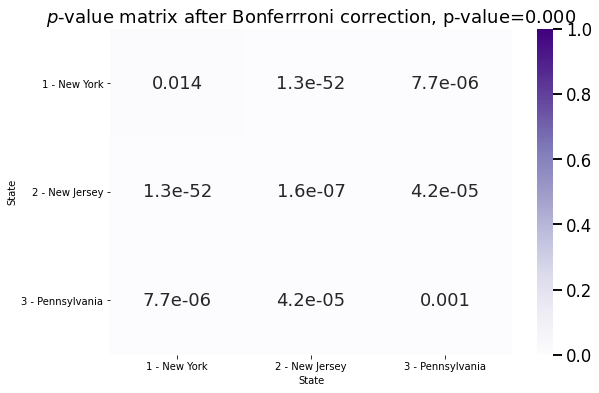

In [12]:
fig, ax = plt.subplots(1,1, figsize=(9, 6))
plot_block(Pvals, ax=ax, title="$p$-value matrix after Bonferrroni correction, p-value={:.3f}".format(pval))

The $p$-values are all *still* below $\alpha=0.05$ after multiple hypothesis correction, so therefore, we accept the alternative hypothesis for every pair of communities that the probabilities differ. Since the alternative hypothesis $H_A: B^{(day)} = B^{(night)}$ only requires this to occur for at least one pair of communities, we accept the alternative hypothesis that the blocks are different. The This can be implemented using the [bilateral connectome package](#link?) `stochastic_block_test`:

In [22]:
from pkg.stats import stochastic_block_test

stat, pvalue, misc = stochastic_block_test(
    Aday, Anight, labels1=z, labels2=z, method="fisher"
)

## Testing whether the block matrices in an SBM are multiples of one another

Back in [Chapter 4](#link?) we learned about a useful summary statistic, known as the *network density*. If you remember, the network density was the quantity:
\begin{align*}
density(A) &= \frac{2\sum_{j > i}a_{ij}}{n(n - 1)}
\end{align*}
Which could be thought of as the "fraction" of edges which actually exist in a network, divided by the fraction of edges which could exist in a network. As it turns out, the network density plays an extremely large role ion virtually every property of networks which we estimate in machine learning, including the block matrices. However, when we talk about two block matrices being different, we might be trying to describe something more than just that their network densities are different. 

For instance, in our example, we know that the probability of an edge existing between two cities is, in general, about $50\%$ higher during the daytime compared to the night time. We don't want to have our answer just be a product of the fact that there were just more edges in the daytime network. Rather, we want to find the *topological* difference between the two networks; that is, that the day time driving patterns between New Jersey and New York towns went *above and beyond* the $50\%$ increase we otherwise had. For this reason, we revamp our hypothesis a little bit.

If you remember, our hypothesis that we ran above was the null hypothesis $H_0: B^{(day)} = B^{(night)}$ that the two block matrices are the same against the alternative $H_A: B^{(day)} \neq B^{(night)}$ that the block matrices differ. We will change this up a little bit. Now, our null hypothesis becomes $H_0: B^{(day)} = a\cdot B^{(night)}$ that the two block matrices are the same *up to a rescaling* against $H_A: B^{(day)} \neq a\cdot B^{(night)}$. How do we interpret this?

In this case, the value $a$ is chosen to be the difference in the expected network densities between the day time and night time networks, the quantity $a = \frac{p^{(day)}}{p^{(night)}}$. In practice, what we use is an estimate of this quantity, $\hat a = \frac{\hat p^{(day)}}{\hat p^{(night)}}$, where $\hat p^{(day)}$ is the network density of the day time network and $\hat p^{(night)}$ is the network density of the night time network.

We address this problem very similarly to above, instead using [Fisher's exact test for non-unity odds ratios](#https://en.wikipedia.org/wiki/Fisher%27s_noncentral_hypergeometric_distribution). We implement this using the [bilateral connectome](#link?) package, again showing the p-value matrix to visualize wiuch combinations of communities are substantially different:

In [43]:
n = np.sum(ns)

density_day = Aday[upper_tri_mask].sum()*2/(n*(n-1))
density_night = Anight[upper_tri_mask].sum()*2/(n*(n-1))

null_odds = density_day/density_night
stat, pvalue, misc = stochastic_block_test(
    Aday, Anight, labels1=z, labels2=z, method="fisher",
    null_odds=null_odds
)
Pval_mtx = misc["uncorrected_pvalues"]

Bnight_adj = Bnight*null_odds

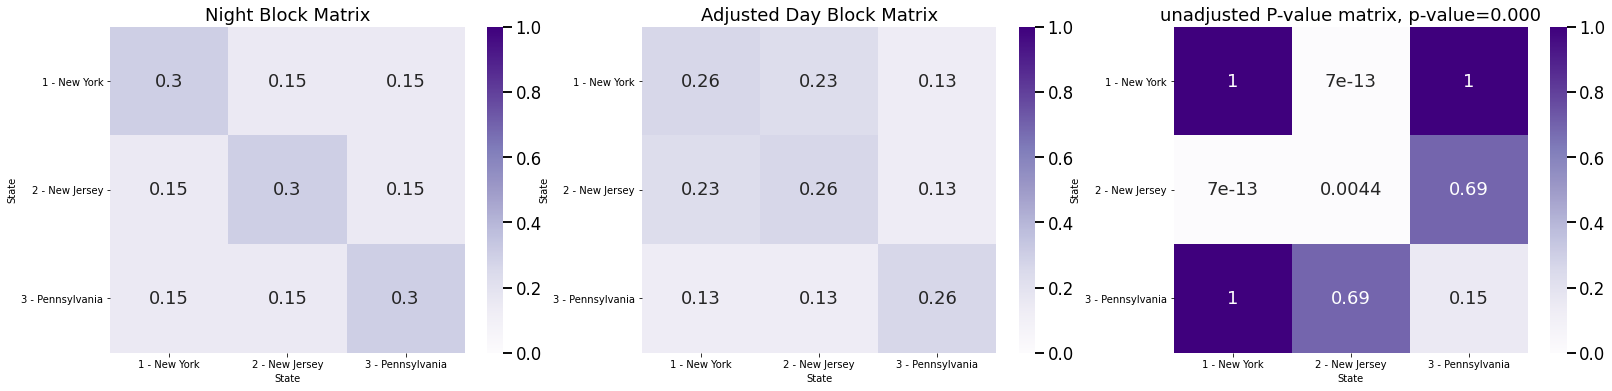

In [44]:
fig, axs = plt.subplots(1, 3, figsize=(27, 6))
plot_block(Bnight, title="Night Block Matrix", ax=axs[0])
plot_block(Bday/null_odds, title="Adjusted Day Block Matrix", ax=axs[1])
plot_block(Pval_mtx, title="unadjusted P-value matrix, p-value={:.3f}".format(pvalue), ax=axs[2])
plt.show()

This shows that after we adjust the block matrix for changes in network density, the difference in the block probability between New York and New Jersey is still significant. This means that the density-adjusted block matrices are different, since the $p$-value is less than $\alpha = 0.05$.